# Опишите теоретическую модель k-средних

KMeans - алгоритм кластеризации, основывающийся на понятии центра масс (каждый кластер будет описываться таким центроидом).

Рассмотрим выборку ${x_1, ..., x_N}$.
Зададим как гиперпараметр желаемое количество кластеров - пусть оно будет равно $n$.

Алгоритм следующий:
1. Выберем n случайных/квазислучайных точек из всего пространства, они будут центрами кластеров (${c_1, ..., c_n}$.
2. Задача - минимизировать сумму квадратов расстояний от точек до центроидов их кластеров.
3. Для каждой точки $x_i$ найдем ближайший кластерный центр $c_j$, и отнесем ее туда - таким образом получим кластеры $C_j$.
4. Перемещаем каждый $c_j$ по следующей формуле: $с_j = \frac{1}{|C_j|} \sum_{x \in C_j} x$
5. Повторяем шаги, пока центроиды не перестанут сильно меняться

# Код

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets

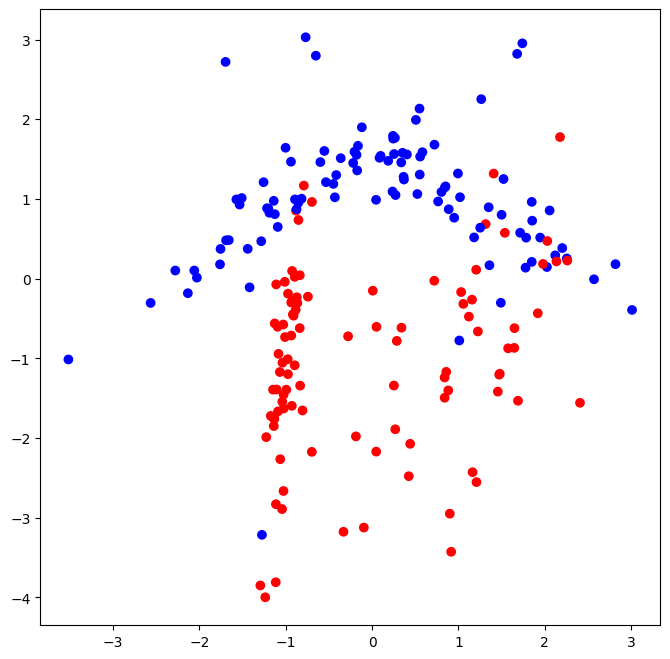

In [43]:
classes = datasets.make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=1)
colors = ListedColormap(["red", "blue"])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

plt.show()

In [44]:
np.random.seed(0)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (140, 2)
Размер массива признаков тестовой выборки (60, 2)
Размер массива ответов для обучающей выборки (140,)
Размер массива ответов для тестовой выборки (60,)


In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [46]:
class LogisticRegression:

    def __init__(self, W: np.ndarray = None, b: np.ndarray = None):
        self.W = W
        self.b = b

    @staticmethod
    def log_loss(Y_predicted: np.ndarray, Y: np.ndarray):
        return -np.mean(Y * np.log(Y_predicted) + (1 - Y) * np.log(1 - Y_predicted))
    @staticmethod
    def log_loss_grads(X: np.ndarray, Y_predicted: np.ndarray, Y: np.ndarray):
        N = X.shape[0]
        dW = (1 / N) * np.dot(X.T, (Y_predicted - Y))
        db = (1 / N) * np.sum(Y_predicted - Y)
        return dW, db

    def predict_probability(self, X: np.ndarray):
        return sigmoid(X @ self.W.T  + self.b)
    def predict(self, X: np.ndarray, threshold=0.5):
        return (self.predict_probability(X) >= threshold).astype(int)

    def fit(self, X: np.ndarray, Y: np.ndarray, epochs: int = 1000, lr = lambda epoch: 0.1) -> np.ndarray:
        if self.W is None:
            self.W = np.random.normal(0, 0.01, X.shape[1]).T
        if self.b is None:
            self.b = 0.0

        losses = np.zeros(epochs)
        for epoch in range(1, epochs + 1):
            Y_predicted = self.predict_probability(X)

            losses[epoch - 1] = LogisticRegression.log_loss(Y_predicted, Y)

            current_lr = lr(epoch)
            dW, db = LogisticRegression.log_loss_grads(X, Y_predicted, Y)
            self.W -= current_lr * dW
            self.b -= current_lr * db
        return losses

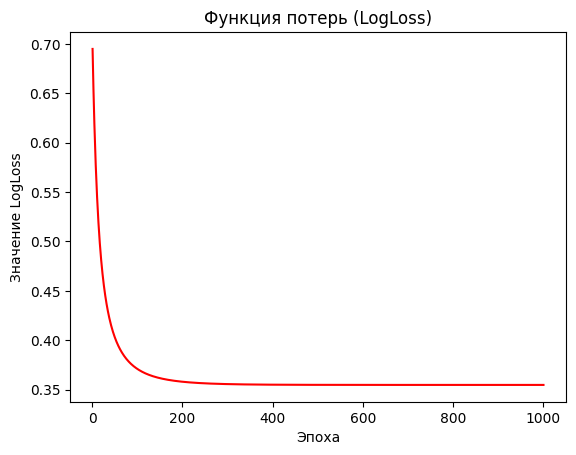

In [47]:
model = LogisticRegression()
losses = model.fit(X_train, y_train)

plt.plot(range(1, 1000 + 1), losses, color = "red")
plt.title("Функция потерь (LogLoss)")
plt.xlabel("Эпоха")
plt.ylabel("Значение LogLoss")

plt.show()

In [48]:
y_predicted_test = model.predict(X_test)
y_predicted_train = model.predict(X_train)

train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test - y_test)*100.0)

print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_train, y_predicted_train,
                          target_names=['Класс 0', 'Класс 1'],
                          digits=3))


Точность на обучающей выборке: 87.857
Точность на тестовой выборке: 83.333
              precision    recall  f1-score   support

     Класс 0      0.855     0.894     0.874        66
     Класс 1      0.901     0.865     0.883        74

    accuracy                          0.879       140
   macro avg      0.878     0.879     0.878       140
weighted avg      0.880     0.879     0.879       140



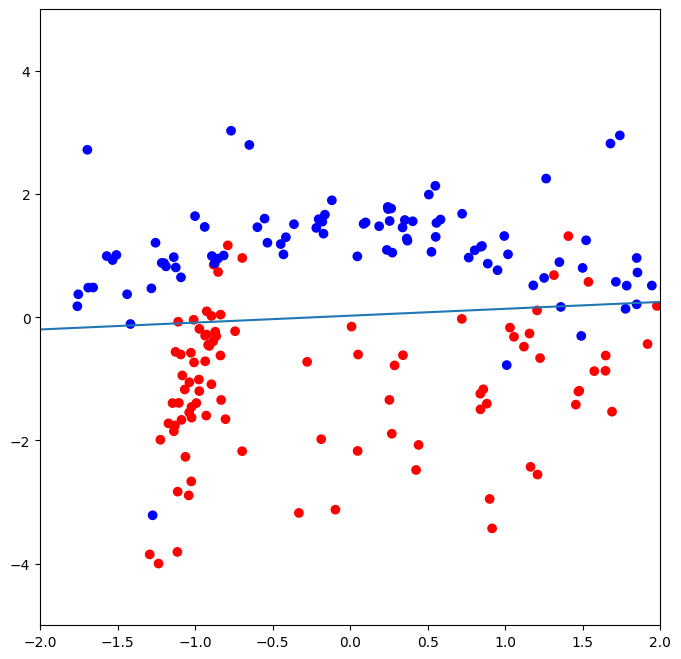

In [49]:
data = np.linspace(-2, 2, 100)

plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-5, 5)
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.plot(data, (-model.W[0] * data - model.b) / model.W[1])

plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

y_pred_train_tree = tree_model.predict(X_train)
y_pred_test_tree = tree_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train_tree):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test_tree):.3f}")
print(classification_report(y_test, y_pred_test_tree, target_names=['Класс 0', 'Класс 1']))

Train accuracy: 0.929
Test accuracy: 0.850
              precision    recall  f1-score   support

     Класс 0       0.93      0.78      0.85        32
     Класс 1       0.79      0.93      0.85        28

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
forest_model.fit(X_train, y_train)

y_pred_train_forest = forest_model.predict(X_train)
y_pred_test_forest = forest_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train_forest):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test_forest):.3f}")
print(classification_report(y_test, y_pred_test_forest, target_names=['Класс 0', 'Класс 1']))

Train accuracy: 0.914
Test accuracy: 0.883
              precision    recall  f1-score   support

     Класс 0       0.93      0.84      0.89        32
     Класс 1       0.84      0.93      0.88        28

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



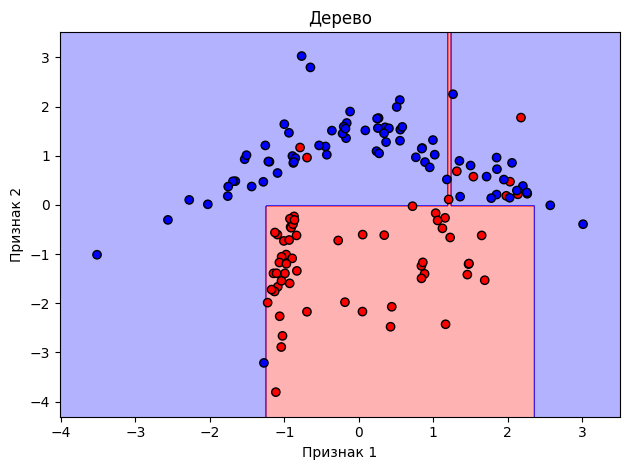

In [58]:
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=colors, edgecolors='k')
plt.title("Дерево")
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

plt.tight_layout()
plt.show()

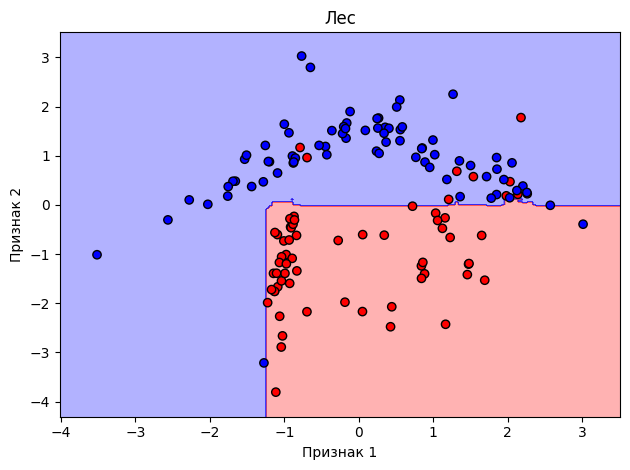

In [59]:
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=colors, edgecolors='k')
plt.title("Лес")
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

plt.tight_layout()
plt.show()

# Метрики для проверки качества алгоритмов регрессии

Для алгоритма регрессии чаще всего используется MSE - среднее квадратов отклонений предсказания от правильного результата: $$ Loss(w, b) = MSE(w, b) = \frac{1}{N} \sum_{i=1}^{N}(f_{w,b}(x_i) - y_i)^2 = \frac{1}{N} \sum_{i=1}^{N}(wx_i + b - y_i)^2 $$
Данная функция выпукла, а потому ее минимум - глобальный.

Существует MAE - среднее абсолютное значение: $$ MAE = \frac{1}{N} \sum^{N}_{i=1} |a(x_{i})-y_{i}|$$

$R^2$ - коэффициент детерминации: $$ R^2 = 1 - \frac{\sum_{i=1}^N (y_i - y_{pred}(x_i))^2}{\sum_{i=1}^N (y_i - y_{выборочное_среднее}) }$$